```{currentmodule} tskit
```

In [1]:
import urllib.request

import tqdm
import tskit
import tszip

class DownloadProgressBar(tqdm.tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download(url, progress=True):
    with DownloadProgressBar(
        unit='B',
        unit_scale=True,
        miniters=1,
        desc=url.split('/')[-1],
        disable=not progress,
    ) as t:
        tmp_fn, _ = urllib.request.urlretrieve(url, reporthook=t.update_to)
        try:
            ts = tskit.load(tmp_fn)
        except tskit.FileFormatError:
            # could be a tsz file
            ts = tszip.decompress(tmp_fn)
        urllib.request.urlcleanup() # Remove tmp_fn
    return ts

def download_unified_genealogy():
    keep_span = [108_000_000, 110_000_000]  # cut down to this genome region
    keep_regions = {"EastAsia", "EAST_ASIA", "AFRICA", "Africa"}

    # Downloads 138 Mb of data - this may take a while
    tables = download(
        "https://zenodo.org/record/5512994/files/"
        "hgdp_tgp_sgdp_high_cov_ancients_chr2_q.dated.trees.tsz"
    ).dump_tables()
    tables.keep_intervals([keep_span])
    tables.populations.metadata_schema = tskit.MetadataSchema.permissive_json()
    tables.sites.metadata_schema = tskit.MetadataSchema.permissive_json()
    ts = tables.tree_sequence()
    ts = ts.simplify([
        u
        for u in ts.samples()
        if (
            ts.population(ts.node(u).population).metadata.get("region") in keep_regions
            or ts.population(ts.node(u).population).metadata.get("name") == "Denisovan"
        )
    ])
    tszip.compress(ts, "data/unified_genealogy_2q_108Mb-110Mb.tsz")

def create_notebook_data():
    download_unified_genealogy()

# create_notebook_data()  # uncomment to recreate the tree seqs used in this notebook

(sec_intro_popgen)=

# `Tskit` for population genetics

{ref}`Tskit<tskit:sec_introduction>`, the tree sequence toolkit, brings the power of
evolutionary trees to the field of population genetics. The
{ref}`succinct tree sequence<sec_what_is>` format
is designed to store DNA sequences jointly with their ancestral history (the
"genetic genealogy" or {ref}`ARG<sec_args>`). Storing population genetic data in this
form enables highly efficient computation and analysis.

The core `tskit` library provides methods for storing genetic data, a flexible
analysis framework, and APIs to build your own efficient population genetic algorithms.
Because of its speed and scalability, `tskit` is well-suited to interactive analysis of
large genomic datasets. 

## Population genetic simulation

Several simulation tools output tree sequences. Below we use the
standard library for population genetic simulation models
([stdpopsim](https://popsim-consortium.github.io/)) to generate a model of
*Homo sapiens*, in which African, Eurasian,
and Asian populations combine to generate a mixed American population. We can use the
[demesdraw](https://pypi.org/project/demesdraw/) package to plot a schematic of the
migrations and population size changes that define this model.

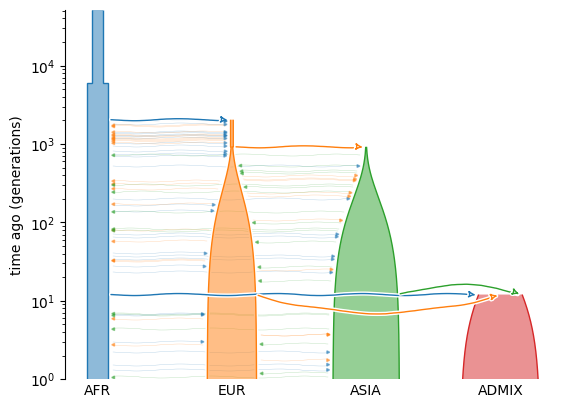

In [2]:
import stdpopsim
import demesdraw
from matplotlib import pyplot as plt

species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("AmericanAdmixture_4B11")

# Plot a schematic of the model
demesdraw.tubes(model.model.to_demes(), ax=plt.gca(), seed=1, log_time=True)
plt.show()

Genomic data in tree sequence format can be generated via the widely-used
[msprime](https://tskit.dev/software/msprime.html) simulator. Here we simulate 20
kilobases of genome sequence at the start of human chromosome 1 under this model,
together with its evolutionary history. We generate 16 diploid genomes: 4 from each of
the populations in the model. The DNA sequences and their ancestry are stored in a
succinct tree sequence named `ts`:

In [3]:
contig = species.get_contig("chr1", mutation_rate=model.mutation_rate, right=20_000)
samples = {"AFR": 4, "EUR": 4, "ASIA": 4, "ADMIX": 4} # 16 diploid samples
engine = stdpopsim.get_engine("msprime")
ts = engine.simulate(model, contig, samples, seed=9)
print(f"Simulated a tree sequence of {ts.num_samples} haploid genomes:")
print(f"{ts.num_sites} variable sites over {ts.sequence_length} base pairs")

Simulated a tree sequence of 32 haploid genomes:
39 variable sites over 20000.0 base pairs


We can now inspect alleles and their frequencies at the variable sites we have simulated
along the genome:

In [4]:
for v in ts.variants():
    display(v)
    if v.site.id >= 2: #  Only show site 0, 1, and 2, for brevity
        break

Or we can display the {meth}`~TreeSequence.haplotypes` (i.e. the variable sites) for
each sample

In [5]:
samples = ts.samples()
for sample_id, h in zip(samples, ts.haplotypes(samples=samples)):
    pop = ts.node(sample_id).population
    print(f"Sample {sample_id:<2} ({ts.population(pop).metadata['name']:^5}): {h}")

Sample 0  ( AFR ): CCCACGCGCGGTACAATCTTTGTGACCGTTAGAGCTTTA
Sample 1  ( AFR ): CCCAAACGCAGTACAACGTCAGGGACCGTTAGAGCTTGG
Sample 2  ( AFR ): ACAACGCGCGTTACAATCTTTGTGACCGTTAGAGCTTTG
Sample 3  ( AFR ): CCCAAACGCAGTACAACCTCAGGGACCGTTAGAGCTTTA
Sample 4  ( AFR ): CCCAAACCTAGTAAAACCTCATGGCCCGTTAGTGCGCTT
Sample 5  ( AFR ): ACAACGCGCGGTACAATCTTTGTAACCGTTAGAGCTTTA
Sample 6  ( AFR ): CCCAAACCTAGTAAAACCTCATGGCCCGTTAGTGCGCTT
Sample 7  ( AFR ): CCCAAACGCAGTACAACCTCAGGGACCGTTAGAGCTTTA
Sample 8  ( EUR ): ACAACGCGCGGTACAATCTTTGTAACCGTTAGAGCTTTG
Sample 9  ( EUR ): ACAACGCGCGGTACAATCTTTGTAAGCGTTAGAGCTTTG
Sample 10 ( EUR ): AAAACGCGCGGTACAATCTTTGTAACCGTAAGAGCTTTG
Sample 11 ( EUR ): ACAACGCGCGGTACAATCTTTGTAACCGTTAGAGCTTTG
Sample 12 ( EUR ): ACAACGCGCGGTACAATCTTTGTAACCGTAAGAGCTTTG
Sample 13 ( EUR ): ACAACGCGCGGTACAATCTTTGTAACCGTAAGAGCTTTG
Sample 14 ( EUR ): ACAACGCGCGGTACAATCTTTGTAACCGTAAGAGCTTTG
Sample 15 ( EUR ): ACAACGCGCGGTACAATCTTTGTAACCGTAAGAGCTTTG
Sample 16 (ASIA ): ACAACGCGCGGTACAATCTTTGTAAGCGTTAGAGCTT

From the tree sequence it is easy to obtain the
{meth}`TreeSequence.allele_frequency_spectrum` for the entire region (or for
{ref}`windowed regions<sec_tskit_getting_started_compute_statistics_windowing>`)

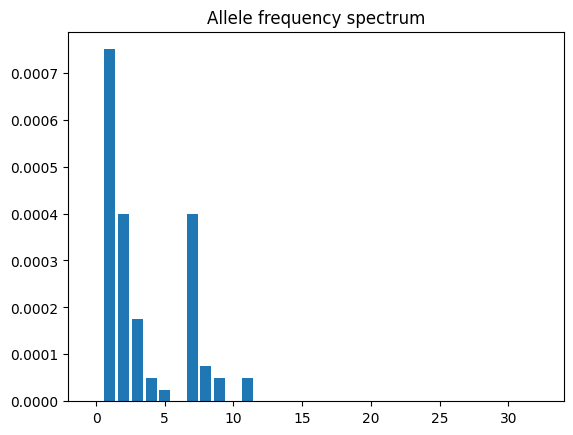

In [6]:
afs = ts.allele_frequency_spectrum()
plt.bar(range(ts.num_samples + 1), afs)
plt.title("Allele frequency spectrum")
plt.show()

Similarly `tskit` allows fast and easy
{ref}`calculation of statistics<sec_tutorial_stats>` along the genome. Here is
a plot of windowed $F_{st}$ between Africans and admixed Americans over this short
region of chromosome:

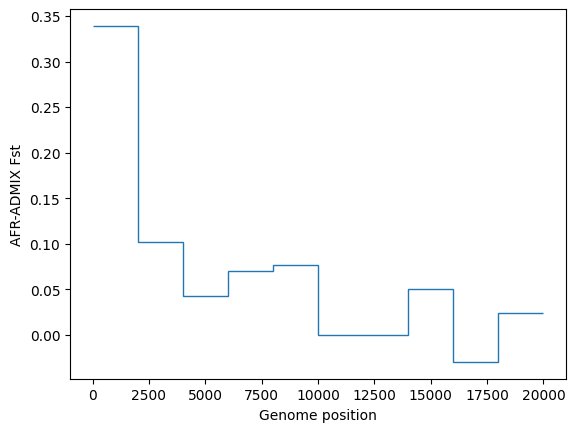

In [7]:
# Define the samples between which Fst will be calculated
pop_id = {p.metadata["name"]: p.id for p in ts.populations()}
sample_sets=[ts.samples(pop_id["AFR"]), ts.samples(pop_id["ADMIX"])]

# Do the windowed calculation, using windows of 2 kilobases
windows = list(range(0, int(ts.sequence_length + 1), 2_000))
F_st = ts.Fst(sample_sets, windows=windows)

# Plot
plt.stairs(F_st, windows, baseline=None)
plt.ylabel("AFR-ADMIX Fst")
plt.xlabel("Genome position")
plt.show()

Extracting the genetic tree at a specific genomic location is easy using `tskit`, which
also provides methods to {ref}`plot<sec_tskit_viz>` these trees. Here we
grab the tree at position 10kb, and colour the different populations by
different colours, as described in the {ref}`viz tutorial<sec_tskit_viz_styling>`:

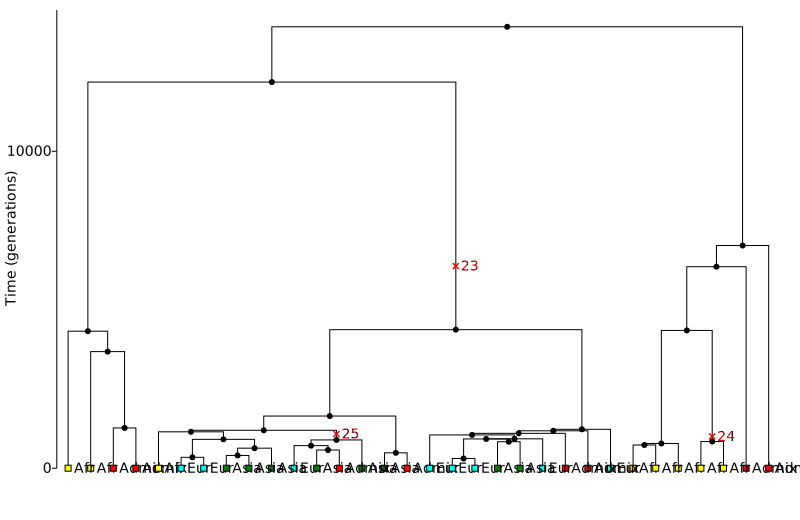

In [8]:
tree = ts.at(10_000)

colours = dict(AFR="yellow", EUR="cyan", ASIA="green", ADMIX="red")
styles = [
    f".leaf.p{pop.id} > .sym {{fill: {colours[pop.metadata['name']]}}}"
    for pop in ts.populations()
]

styles += [ # rotate the population labels, etc
    ".leaf > .lab {text-anchor: start; transform: rotate(90deg) translate(6px)}",
    ".leaf > .sym {stroke: black}"
]

labels = { # Label samples by population
    u: ts.population(ts.node(u).population).metadata["name"].capitalize()
    for u in ts.samples()
}

tree.draw_svg(
    size=(800, 500),
    canvas_size=(800, 520),
    node_labels=labels,
    style="".join(styles),
    y_axis=True,
    y_ticks=range(0, 30_000, 10_000)
)


## Population genetic inference

If, instead of simulations, you want to analyse existing genomic data (for example
stored in a VCF file), you will need to infer a tree sequence from it, using e.g.
[tsinfer](https://tskit.dev/tsinfer/docs/stable/). Here we load an illustrative portion
of an [inferred tree sequence](https://zenodo.org/record/5512994)
based on about 7500 public human genomes, including genomes from the
[Thousand Genomes Project](https://www.internationalgenome.org/data-portal/data-collection/grch38) and
[Human Genome Diversity Project](https://www.internationalgenome.org/data-portal/data-collection/hgdp).
The genomic region encoded in this tree sequence has been cut down to
span positions 108Mb-110Mb of human chromosome 2, which spans the
[EDAR](https://en.wikipedia.org/wiki/Ectodysplasin_A_receptor) gene.

Note that tree sequence files are usually imported using {func}`load`,
but because this file has been additionally compressed, we load it via
{func}`tszip:tszip.decompress`:

In [9]:
import tszip
ts = tszip.decompress("data/unified_genealogy_2q_108Mb-110Mb.tsz")

# The ts encompasses a region on chr 2 with an interesting SNP (rs3827760) in the EDAR gene
edar_gene_bounds = [108_894_471, 108_989_220]  # In Mb from the start of chromosome 2
focal_variant = [v for v in ts.variants() if v.site.metadata.get("ID") == "rs3827760"].pop()
print("An interesting SNP within the EDAR gene:")
focal_variant

An interesting SNP within the EDAR gene:


For simplicity, this tree sequence has been {ref}`simplified<sec_simplification>` to
include only those samples from the African and East Asian regions. These belong to a
number of populations. The population information, as well as information describing the
variable sites, is stored in tree sequence {ref}`metadata<sec_tutorial_metadata>`:

In [10]:
import pandas as pd

print(ts.num_populations, "populations defined in the tree sequence:")

pop_names_regions = [
    [p.metadata.get("name"), p.metadata.get("region")]
    for p in ts.populations()
]
display(pd.DataFrame(pop_names_regions, columns=["population name", "region"]))

67 populations defined in the tree sequence:


,population name,region
0,BantuKenya,AFRICA
1,BantuSouthAfrica,AFRICA
2,Biaka,AFRICA
3,Cambodian,EAST_ASIA
4,Dai,EAST_ASIA
...,...,...
62,Uygur,EastAsia
63,Xibo,EastAsia
64,Yi,EastAsia
65,Yoruba,Africa


You can see that there are multiple African and East asian populations, grouped by
region. Here we collect two lists of IDs for the sample
{ref}`nodes<sec_terminology_nodes>` from the African region and from the East asian
region:

In [11]:
sample_lists = {}
for n, rgns in {"Africa": {'AFRICA', 'Africa'}, "East asia": {'EAST_ASIA', 'EastAsia'}}.items():
    pop_ids = [p.id for p in ts.populations() if p.metadata.get("region") in rgns]
    sample_lists[n] = [u for p in pop_ids for u in ts.samples(population=p)]

With these lists we can calculate different windowed statistics
(here {meth}`genetic diversity<TreeSequence.diversity>` and
{meth}`Tajima's D<TreeSequence.Tajimas_D>`) within each of these regions:

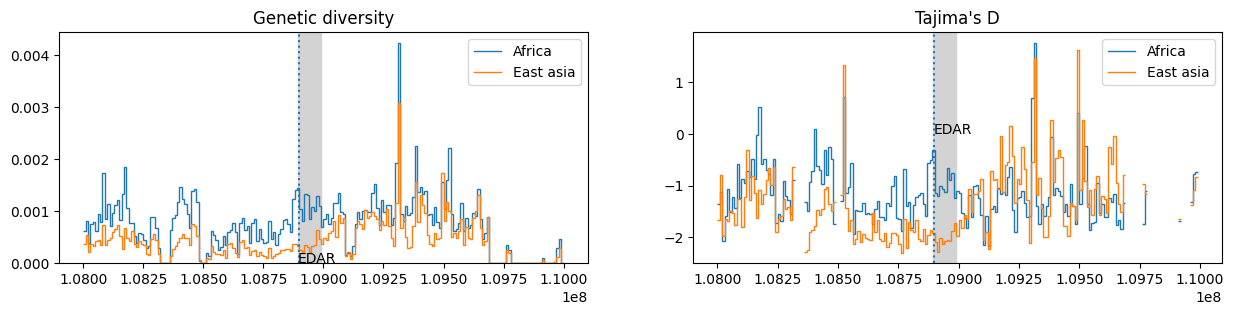

In [12]:
edar_ts = ts.trim()  # remove regions with no data (changes the coordinate system)
windows = list(range(0, int(edar_ts.sequence_length)+1, 10_000))
data = {
    "Genetic diversity": {
        region: edar_ts.diversity(samples, windows=windows)
        for region, samples in sample_lists.items()
    },
    "Tajima's D": {
        region: edar_ts.Tajimas_D(samples, windows=windows)
        for region, samples in sample_lists.items()
    },  
}

# Plot the `data`
fig, axes = plt.subplots(ncols=2, figsize=(15, 3))
start = ts.edges_left.min()  # the empty amount at the start of the tree sequence

for (title, plot_data), ax in zip(data.items(), axes):
    ax.set_title(title)
    ax.axvspan(edar_gene_bounds[0], edar_gene_bounds[1], color="lightgray")
    ax.axvline(focal_variant.site.position, ls=":")
    for label, stat in plot_data.items():
        ax.stairs(stat, windows+start, baseline=None, label=label)
    ax.text(edar_gene_bounds[0], 0, "EDAR")
    ax.legend()
plt.show()

Other population genetic libraries such as
[scikit-allel](https://scikit-allel.readthedocs.io/en/stable/) (which is
{ref}`interoperable<sec_tskit_getting_started_exporting_data_allel>` with `tskit`)
could also have been used to produce the plot above. In this case, the advantage of
using tree sequences is simply that they allow these sorts of analysis to
{ref}`scale<plot_incremental_calculation>` to datasets of millions of whole genomes.


However, because this inferred tree sequence stores (an estimate of) the underlying
genealogy, we can also derive statistics based on genealogical relationships. For
example, this tree sequence also contains a sample genome based on an ancient
genome, a [Denisovan](https://en.wikipedia.org/wiki/Denisovan) individual. We can
look at the closeness of relationship between samples from the different geographical
regions and the Denisovan:

:::{todo}
Show an example of looking at topological relationships between the Denisovan and
various East Asian groups, using the {ref}`sec_counting_topologies` functionality.
:::

## Further information

This brief introduction is meant as a simple taster. Many other efficient population
genetic {ref}`analyses<sec_analysing_tree_sequences>` are possible when you have
genomic data stored as a tree sequence.

The rest of the {ref}`tutorials<sec_intro>` contain a large number of examples which
are relevant to population genetic analysis and research. You can also visit the
[learning section](https://tskit.dev/learn/) of the [tskit website](https://tskit.dev/).